<a href="https://colab.research.google.com/github/LuigiSigillo/CartoonGAN/blob/main/CartoonGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
import os
import json
import re
import cv2
import numpy as np
from PIL import Image, ImageFilter
import sys
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import tensorflow as tf
drive.mount('/content/drive')
#!unzip /content/drive/My\ Drive/NN/spirited_away.zip -d /content/drive/My\ Drive/NN/
#!ls /content/drive/My\ Drive/NN/
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found GPU at: /device:GPU:0


# Utils

###Save model

In [ ]:
models_dir = "/content/drive/My Drive/NN/"

def savemodel(model,problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    model.save(filename)
    print("\nModel saved successfully on file %s\n" %filename)

# Save the model MWI-Dataset-1.1_models
savemodel(model,'Twd_model_31_epochs_2000_images')


### Load model

In [ ]:
from keras.models import load_model

models_dir = "/content/drive/My Drive/NN/"
model_name = "towards_model_100_epochs_2000_images_acc44_256"

def loadmodel(problem):
    filename = os.path.join(models_dir, '%s.h5' %problem)
    try:
        model = load_model(filename)
        print("\nModel loaded successfully from file %s\n" %filename)
    except OSError:    
        print("\nModel file %s not found!!!\n" %filename)
        model = None
    return model

model = loadmodel(model_name)

### Load datasets

In [2]:
#load imgs ?
data_dir = '/content/drive/My Drive/NN/photos_rszd'
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,   validation_split=0.2, horizontal_flip=True)

train_gen = train_datagen.flow_from_directory(
        data_dir,
        subset="training",
        seed=123,
        target_size=(256, 256),
        batch_size=32
        )
validation_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(256,256),
        batch_size=32,
        )


Found 2998 images belonging to 1 classes.
Found 3747 images belonging to 1 classes.


# 1 - Image Preprocessing

### 1.1 - Resizing images


In [ ]:
def resize(path):
    for item in os.listdir(path):
            im = Image.open(path+item)
            f, e = os.path.splitext(item)
            imResize = im.resize((256,256), Image.ANTIALIAS)
            print(f)
            imResize.save(path+"_resized/" + f + ' resized.jpg', 'JPEG', quality=90)

resize('/content/drive/My Drive/NN/your_name')

### 1.2 Apply canny, dilate edge and gaussian

In [ ]:
def edge_smoothing(cartoon_images_filename, smoothed_images_filename):
    print("Edge-smoothing of ", cartoon_images_filename)
    origin = cv2.imread(cartoon_images_filename)
    edges = createEdgesOverlay(origin)
    result = overlayEdges(edges, origin)
    #show_images(origin, edges, result)
    result.save(smoothed_images_filename, "JPEG")

def overlayEdges(edges, origin):
    background = transformFromCV2ToPillowImageFormat(origin)
    background.paste(edges, (0, 0), edges)
    background = background.convert("RGB")
    return background

def transformFromCV2ToPillowImageFormat(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    return Image.fromarray(img)

def createEdgesOverlay(origin):
    edges = cv2.Canny(origin, 30, 300, 3) 
    edges = cv2.dilate(edges, (3, 3))
    edges = cv2.bitwise_not(edges)
    edges = transformFromCV2ToPillowImageFormat(edges)
    makeWhiteBackgroundTransparent(edges)
    edges = edges.filter(ImageFilter.GaussianBlur) #do blurring here because doing it before making background transparent results in white halo

    return edges

def makeWhiteBackgroundTransparent(img):
    datas = img.getdata()
    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)

def show_images(img,edges,result):
    plt.subplot(131),plt.imshow(img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(132),plt.imshow(edges)
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(133),plt.imshow(result)
    plt.title('Result Image'), plt.xticks([]), plt.yticks([])

    plt.show()
    



path_resized = "/content/drive/My Drive/NN/spirited_away_resized/"
path_smoothed = "/content/drive/My Drive/NN/spirited_away_resized_smoothed/"


for filename in os.listdir(path_resized):
  #filename='scene43626 resized.jpg'
  f = filename.split(" ")[0] + " smoothed"
  cartoon_images_filename = path_resized + filename
  smoothed_images_filename = path_smoothed + f
  edge_smoothing(cartoon_images_filename, smoothed_images_filename)



#2 - GAN

## Initialization Phase

### Load VGG19 weights

In [2]:
from keras import applications
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers



def transferNet(output_layer_name, input_shape):
    
    # download model
    base_model = applications.vgg19.VGG19(weights="imagenet", include_top=False, input_shape=input_shape)
    # get the output tensor from a layer of the feature extractor
    tmp_vgg_output = base_model.get_layer("block4_conv3").output
    tmp_vgg_output = Conv2D(512, (3, 3), activation='linear', padding='same',name='block4_conv4')(tmp_vgg_output)
    
    vgg = Model(inputs=base_model.input, outputs=tmp_vgg_output)
    vgg.load_weights(os.path.expanduser(os.path.join("~", ".keras", "models","vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5")), by_name=True)

    return vgg


input_shape =(256,256,3)
# load the pre-trained model

# choose the layer from which you can get the features 
name_output_extractor = "block4_conv4" #ultimo 3?

# build the transfer model
vgg = transferNet(name_output_extractor, input_shape)
vgg.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

### Generator

In [3]:
from keras import applications
from keras import layers
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras import optimizers
import tensorflow as tf
import tensorflow_addons as tfa


def resblock(x_init):
    x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x_init)
    #x = (ZeroPadding2D(padding=(1, 1)))(x)
    
    x = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True)(x)
    x = tf.nn.relu(x)
    x = (Conv2D(256, kernel_size=3, strides=1, padding='same'))(x)
    #x = (ZeroPadding2D(padding=(1, 1)))(x)
    x = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True)(x)    

    return x + x_init

def generator(input_shape):
    #model = Sequential()
    #k7n64s1
    input_t = tf.keras.layers.Input(shape=input_shape)
    
    model = (Conv2D(input_shape=input_shape, filters=64, kernel_size=7, strides=1, padding='same'))(input_t)
    #model = (ZeroPadding2D(padding=(3, 3)))(model)
    model = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True)(model)
    model = tf.nn.relu(model)
    
    #### Down-Convolution
    
    #k3 n128 s2
    model = (Conv2D(filters=128, kernel_size=3, strides=2, padding='same'))(model)
    #model = (ZeroPadding2D(padding=(1, 1)))(model)
    #k3 n128 s1
    model = (Conv2D(filters=128, kernel_size=3, strides=1, padding='same'))(model)
    #model = (ZeroPadding2D(padding=(1, 1)))(model)
    
    model = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True)(model)
    model = tf.nn.relu(model)


    #k3 n256 s2
    model = (Conv2D(filters=256, kernel_size=3, strides=2, padding='same'))(model)
    #model = (ZeroPadding2D(padding=(1, 1)))(model)

    #k3 n256 s1
    model = (Conv2D(filters=256, kernel_size=3, strides=1, padding='same', name="test"))(model)
    #model = (ZeroPadding2D(padding=(1, 1)))(model)
    
    model = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True)(model)
    model = tf.nn.relu(model)



    #TODO
    # residual blocks
    for i in range(8):#number of res blocks
        '''model = (Conv2D(256, kernel_size=3, strides=1, padding='valid',activation="relu"))(model)
        model = (ZeroPadding2D(padding=(1, 1)))(model)
        
        model = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True)(model)
        model = tf.nn.relu(model)

        model = (Conv2D(256, kernel_size=3, strides=1, padding='valid',activation="relu"))(model)
        model = (ZeroPadding2D(padding=(1, 1)))(model)
        model = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True)(model)'''
        model = resblock(model)

        
        
    
    # Up-convolution
    model = (Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same',output_padding=1))(model)
    #model = (ZeroPadding2D(padding=(1, 1)))(model)
    
    model = (Conv2D(filters=128, kernel_size=3, strides=1, padding='same'))(model)
    #model = (ZeroPadding2D(padding=(1, 1)))(model)
    
    model = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True)(model)
    model = tf.nn.relu(model)
    #######################
    model = (Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same',output_padding=1))(model)
    #model = (ZeroPadding2D(padding=(1, 1)))(model)
    
    model = (Conv2D(filters=64, kernel_size=3, strides=1, padding='same'))(model)
    #model = (ZeroPadding2D(padding=(1, 1)))(model)

    model = tfa.layers.InstanceNormalization(axis=3, center=True, scale=True)(model)
    model = tf.nn.relu(model)

    ###
    model = (Conv2D(filters=3, kernel_size=7, strides=1, padding='same'))(model)
    #model = (ZeroPadding2D(padding=(3, 3)))(model)
    model = tf.tanh(model)

    #model.compile(loss=tf.keras.losses.BinaryCrossentropy)
    model = Model(inputs=input_t, outputs=model, name="generator")

    return model

G = generator(input_shape=(256,256,3))
#G.build(input_shape=(256,256,3)) #todo
#G.summary()


#### Generator training

Starting to pretrain generator with 10 epochs...
Building `photos_rszd/photos_resized` dataset
Found 3747  images in train folder.
Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


Pretrain Epoch 1/10:   0%|          | 0/235 [00:00<?, ?it/s]

Setting up optimizer to update generator's parameters...
Proceeding pretraining without sample images...
Starting pre-training loop, setting up summary writer to record progress on TensorBoard...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Pretrain Epoch 1/10:   0%|          | 0/235 [00:06<?, ?it/s]


TypeError: ignored

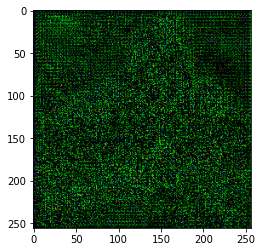

In [4]:
#TODO
from glob import glob
import os
from tqdm import tqdm
import gc
import matplotlib.pyplot as plt
def get_dataset(dataset_name, _type, batch_size):
    files = glob(os.path.join('/content/drive/My Drive/NN/', dataset_name, "*"))
    num_images = len(files)
    print(f"Found {num_images}  images in {_type} folder.")
    ds = tf.data.Dataset.from_tensor_slices(files)
    ds = ds.apply(tf.data.experimental.shuffle_and_repeat(num_images))

    def fn(filename):
        x = tf.io.read_file(filename)
        x = tf.image.decode_jpeg(x, channels=3)
        img = tf.cast(x, tf.float32) / 127.5 - 1
        return img

    #ds = ds.apply(tf.data.Dataset.map(fn))
    #ds = ds.apply(tf.data.Dataset.batch(batch_size))
    ds = ds.apply(tf.data.experimental.map_and_batch(fn, batch_size))
    steps = int(np.ceil(num_images/batch_size))
    # user iter(ds) to avoid generating iterator every epoch
    return iter(ds), steps


def pretrain_step(vgg, input_images, generator, optimizer):
    with tf.GradientTape() as tape:
        generated_images = generator(input_images)
        plt.imshow(generated_images[0])
        #print(vgg(generated_images), "/ntipo??",type(vgg(generated_images)))
        c_loss = tf.keras.losses.MeanAbsoluteError(vgg(input_images), vgg(generated_images))
    gradients = tape.gradient(c_loss, generator.trainable_variables)
    optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    content_loss_metric(c_loss)

def pretrain_generator(dataset_name,batch_size):
    summary_writer = tf.summary.create_file_writer(os.path.join('/content/drive/My Drive/NN', "pretrain"))
    print(f"Starting to pretrain generator with 10 epochs...")
    print(f"Building `{dataset_name}` dataset")
    dataset, steps_per_epoch = get_dataset(dataset_name=dataset_name,
                                                _type="train",
                                                batch_size=batch_size)
    
    generator = G
    #generator(tf.keras.Input(shape=(None,256,256, 3)))
    #generator.summary()

    print("Setting up optimizer to update generator's parameters...")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008, beta_1=0.5)

    trained_epochs = 0
    epochs = 10

    print("Proceeding pretraining without sample images...")

    print("Starting pre-training loop, setting up summary writer to record progress on TensorBoard...")

    for epoch in range(epochs):
        epoch_idx = trained_epochs + epoch + 1

        for step in tqdm(range(1, steps_per_epoch + 1), desc=f"Pretrain Epoch {epoch + 1}/{epochs}"):
            image_batch = dataset.next()
            pretrain_step(vgg, image_batch, generator, optimizer)

            if step % 100 == 0: #100 = pretrain_reporting_steps
                global_step = (epoch_idx - 1) * steps_per_epoch + step
                with summary_writer.as_default():
                    tf.summary.scalar('content_loss', tf.keras.metrics.Mean("content_loss", dtype=tf.float32).result(), step=global_step)

                tf.keras.metrics.Mean("content_loss", dtype=tf.float32).reset_states()
        gc.collect()
        
pretrain_generator("photos_rszd/photos_resized", 16)

In [5]:
y_true = [[0., 1.], [0., 0.]]
y_pred = [[1., 1.], [1., 0.]]
mae = tf.keras.losses.MeanAbsoluteError()
mae(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

## Discriminator

In [ ]:
def discriminator():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='valid',activation=LeakyReLU()))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='valid',activation=LeakyReLU(alpha=0.2)))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='valid',activation=LeakyReLU(alpha=0.2)))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=128, kernel_size=3, strides=2, padding='valid',activation=LeakyReLU(alpha=0.2)))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding='valid',activation=LeakyReLU(alpha=0.2)))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(BatchNormalization())
        
    model.add(Conv2D(filters=256, kernel_size=3, strides=1, padding='valid',activation=LeakyReLU(alpha=0.2)))
    model.add(ZeroPadding2D(padding=(1, 1)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=1, kernel_size=3, strides=1, padding='valid',activation="sigmoid"))
    model.add(ZeroPadding2D(padding=(1, 1)))
    
    #model.compile(loss=tf.keras.losses.BinaryCrossentropy)
    return model


D = discriminator()
D.build(input_shape=(None,256,256,3)) #todo
D.summary()  

## Adversarial model

In [ ]:
def create_GAN():
    optimizer = tf.keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)

    discriminator_model = Sequential()
    discriminator_model.add(D)
    discriminator_model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])

    optimizer = tf.keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
    adv_model = Sequential()
    adv_model.add(G)
    adv_model.add(D)
    adv_model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return adv_model

### Train

In [ ]:
adv_model = create_GAN()
adv_model.fit(
        train_gen,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800,
        verbose=1)

Epoch 1/50
